In [2]:
from perlin_noise import PerlinNoise
import numpy as np
import matplotlib.pyplot as plt
import random

# Signal Optimisation

Adapted from  Emma Thomson (C) 2022. Full description:

> Branch and bound optimisation for a a bloch simulation of a two compartment
model with a semipermeable barrier 


>Author: Emma Thomson
Year: 2022
Institution: Centre for Medical Image Computing: University College London
Email: e.thomson.19@ucl.ac.uk

>Code Adapted From: Lilian Besson, (C) 2017. 
https://github.com/Naereen/notebooks/blob/master/Simulated_annealing_in_Python.ipynb

In [1]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt  # to plot
from sklearn.metrics import mean_squared_error
#import math
import os
import numpy.matlib as mat 
import sys

sys.path.insert(0, "./functions/")
from DictionaryGeneratorFast import DictionaryGeneratorFast

Define parameters for the simulation

In [17]:
''' ----------------------SPECIFY PARAMETERS------------------------------ '''
noOfIsochromatsX = 1000
noOfIsochromatsY = 1
noOfIsochromatsZ = 10
noOfRepetitions = 2000


# Values of GM T1 tissue/blood, Blood volume (vb), GM T2 tissue from Zhao et al. 2007 
# T2 blood value taken from average range from Powell et al. [55-275]ms

# Format = [tissue, blood]
t1Array = np.array([1122,1627])
t2Array = np.array([71,165])
t2StarArray = np.array([50,21])
res_min = 200
res_max = 1600
vb = 50 # it gets divided by 10 in the simulation
    
# a = maximum magnitude of FA  
a_maxMin = 20/4; a_maxMax = 90/4

# b = stretching factor of the FA repetition
w_aMin = 5*np.pi; w_aMax = 200*np.pi


# c = the frequency that governs the period of the sinusoidal variation
fMin = 2; fMax = 400


# d = minimum TR 
## reduced tr
TRminMin = 4; TRminMax = 100


# e = maximum TR
TRmaxMin = 9; TRmaxMax = 200


# Sequence parameters
samples = 1
dictionaryId = 'Discard'
instance = 25
noise = 1 # no noise
multi = 100
invSwitch = True
CSFnullswitch = True
sliceProfileSwitch = True
sequence = 'FISP'

 
interval = np.array([[a_maxMin,a_maxMax],[w_aMin, w_aMax],[fMin,fMax],[TRminMin,TRminMax],\
                    [TRmaxMin, TRmaxMax]])



### Helper Functions

__Generating the parameter variation in TR and FA__

In [18]:
def sinusoidal_TR(TRmax, TRmin, freq, N, instance, save = True):
    N_arr = np.linspace(0,N,num=N)
    trArray = (TRmax*np.sin(N_arr/freq)+(TRmax+TRmin))

    if CSFnullswitch == True: 
        trArray[0] = 2909

    if save == True:
     #Save array for calling in the main function later
        np.save('./functions/holdArrays/trArray_' + str(instance) + '.npy', trArray)
    
    return trArray

def sinusoidal_FA(a_max, N, w_a, instance, save = True):
    N_arr = np.array(range(N))

    faArray = np.squeeze(a_max*(np.abs(3*np.sin(N_arr/w_a)+(np.sin(N_arr/w_a)**2))))*0.25 # sinusoid has a maximum value of 4, hence times by 0.25 to control the height
                         
    # There may be a loss of SNR when the first flip angle is v low (e.g. 0.008)
    # so change the first flip angle to be a little higher
    #faArray[0] = 3
    # 
    if CSFnullswitch == True:
            faArray[0] = 180

    #Save array for calling in the main function later
    if save == True:
        np.save('./functions/holdArrays/faArray_'  + str(instance) + '.npy', faArray)
    return faArray

def fourier_TR(A_0, A_k, B_k, T, N_ter, N):
    # Time points
    t = np.linspace(0, T, N)

    # Compute the Fourier series
    trArray = A_0 + np.zeros_like(t)
    for n in range(1, N_ter + 1):
        trArray += A_k[n-1] * np.cos(2 * np.pi * n * t / T) + B_k[n-1] * np.sin(2 * np.pi * n * t / T)
    return trArray

     
     

__Cost Function__

In [19]:
def func(a_max, w_a, freq, TRmin, TRmax, trVariation, N, instance):
    # Initial guess
        trArray = sinusoidal_TR(TRmax, TRmin, freq, N, instance, save = False)
        faArray = sinusoidal_FA(a_max, N, w_a, instance, save = False)
        readTRFA= False
        
        dictionaryGeneratorMin = DictionaryGeneratorFast(t1Array, t2Array, t2StarArray, noOfIsochromatsX,\
                noOfIsochromatsY, noOfIsochromatsZ, noOfRepetitions, noise, vb/10, res_min,\
                multi/100, invSwitch, CSFnullswitch, sliceProfileSwitch, samples, dictionaryId, sequence, instance, readTRFA, trArray, faArray)
        
        dictionaryGeneratorMax = DictionaryGeneratorFast(t1Array, t2Array, t2StarArray, noOfIsochromatsX,\
                noOfIsochromatsY, noOfIsochromatsZ, noOfRepetitions, noise, vb/10, res_max,\
                multi/100, invSwitch, CSFnullswitch, sliceProfileSwitch, samples, dictionaryId, sequence, instance, readTRFA, trArray, faArray)
        
        signalMin = dictionaryGeneratorMin.MRFSGRE()[:,0]
        signalMax = dictionaryGeneratorMax.MRFSGRE()[:,0]


        return -np.sqrt(mean_squared_error(signalMin, signalMax)) # - rmse

def costFunction(a_max, w_a, freq, TRmin, TRmax, trVariation, N, instance):
        """ Cost of x = f(x)."""
        return func(a_max, w_a, freq, TRmin, TRmax, trVariation, N, instance)


__Initialising Random Selection of Point in Parameter Space__

In [20]:
def start(trVariation, faVariation):
    """ Random point in the interval."""
    if trVariation == 'sin' and faVariation == 'sin':
        a_max = interval[0,0] + (interval[0,1] - interval[0,0]) * rn.random_sample()
        w_a = interval[1,0] + (interval[1,1] - interval[1,0]) * rn.random_sample()
        f = interval[2,0] + (interval[2,1] - interval[2,0]) * rn.random_sample()
        TRmin = interval[3,0] + (interval[3,1] - interval[3,0]) * rn.random_sample()
        TRmax = interval[4,0] + (interval[4,1] - interval[4,0]) * rn.random_sample()
        return a_max, w_a, f, TRmin, TRmax
    
    if trVariation =='fourier' and faVariation == 'sin':
        a_max = interval[0,0] + (interval[0,1] - interval[0,0]) * rn.random_sample()
        w_a = interval[1,0] + (interval[1,1] - interval[1,0]) * rn.random_sample()
        A_0 = interval[2,0] + (interval[2,1] - interval[2,0]) * rn.random_sample()
        A_k = interval[3,0] + (interval[3,1] - interval[3,0]) * rn.random_sample()
        B_k = interval[4,0] + (interval[4,1] - interval[4,0]) * rn.random_sample()
        T = interval[5,0] + (interval[5,1] - interval[5,0]) * rn.random_sample()
        N_ter = interval[6,0] + (interval[6,1] - interval[6,0]) * rn.random_sample()
        return a_max, w_a, A_0, A_k, B_k, T, N_ter


__Plotting Evolution Of States__

In [21]:
def seeBnB(states, costs):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,5, forward=True)
    ax1.plot(states[:,0],'#1b9e77')
    ax1.plot(states[:,1],'#d95f02')
    ax1.plot(states[:,2],'#7570b3')
    ax1.plot(states[:,3],'#e7298a')
    ax1.plot(states[:,4],'#66a61e')
    ax1.set_title("Parameter Variation")
    ax1.legend(["a_max","w_a","f","TRmin","TRmax"])
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Parameter Value")

    ax2.plot(-costs, '#1b9e77')
    ax2.set_title("Fitness Function")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Fitness")

    return None

### Parallelised Version of Branch and Bound

In [24]:
if __name__ == '__main__':
    
    #Multiprocessing requires all modules used within the threads to be defined
    #within __main__
    #I think this is a safety feature
    #os.chdir("./functions/")
    #sys.path.insert(0, "./functions/")
    import time
    import itertools
    import multiprocessing as mp
    import platform
    from BnBCost import costFunction
    from multiprocessing import Pool

    trVariation = 'sin'
    faVariation = 'sin'
    maxsteps = 500
    instance = 25
    N = noOfRepetitions

    # Initialise random start point and calculate associated cost according to the type of parameter variation
    if trVariation == 'sin' and faVariation == 'sin':
        a_max, w_a, f, TRmin, TRmax = start(trVariation,faVariation)
        permutation = [a_max, w_a, f, TRmin, TRmax]
        cost = costFunction(permutation)
        # Update the current state
        state = [a_max, w_a, f, TRmin, TRmax]
    
    
    
    states, costs = [state], [cost]
    state = np.array(state)
    n_params = np.size(permutation)

    ## Correct shape of arrays for concatenation 
    state = np.expand_dims(state, axis=0)
    states = np.expand_dims(np.squeeze(states), axis=0)

    ## Set start point current best state 
    bestCost = cost
    bestState = state
    costInd = 0

    # loop over user defined number of iterations
    for it in range (maxsteps):
        
        ## correct dimensions if required 
        if bestState.ndim == 1: 
            bestState = np.expand_dims(bestState, axis=0)
        
        ## save best values to arrays   
        states = np.append(states, bestState, axis=0)
        costs = np.append(costs, bestCost)

        ##  create the permutation array
        if int(np.size(state,0)) == 0 or int(np.size(state,0)) == 1:
               state = bestState
        permutations = state

        ## display the number of open branches 
        print(str(int(np.size(state,0)*5)) + ' open branches.')

              ##  iterate over each branch 
        for jj in range(int(np.size(state,0))):
            
            ## repeat each branch 5 times 
            permutation = mat.repmat(state[jj,:],5,1)
            aHold, bHold, cHold, dHold, eHold = start(trVariation, faVariation)
            stateHold = [aHold,bHold,cHold,dHold,eHold]
            
            ##  permute one pararameter at a time
            for xx in range(5):
               permutation[xx,xx] = stateHold[xx] 
               
            ## add new 5 permutations to the array of states
            permutations = np.append(permutations, permutation, axis=0)
               
        ##  Calculate costs for all states
        with mp.Pool(mp.cpu_count()) as pool:
            costsHold = pool.map(costFunction, permutations)
            
        ##  Remove values lower that the best cost from the branch above 
        indRem = np.array(np.argwhere(costsHold >= bestCost))
        permArray = np.array(permutations)
        for remove in indRem[::-1]:
            permArray = np.delete(permArray,remove, 0)
        state = permArray
        
        ##  find the best state and cost 
        bestCost = np.min(costsHold)
        costInd = np.argmin(costsHold)
        bestState = permutations[costInd,:]

        ##  print state and cost to screen
        ##  write the latest step t ofile

        print('Step = '  + str(it+1) + '/' + str(maxsteps) + '. State =' + \
            str(permutations[costInd,:]) + '. Cost = ' +  str("{:.5e}".format(bestCost)))
        print("  ")
        
    states = np.array(states)
    seeBnB(states, costs)


5 open branches.
Step = 1/500. State =[17.54238759 79.40948832 99.11947268 21.52701357 59.10900417]. Cost = -6.94616e+00
  
30 open branches.
Step = 2/500. State =[17.54238759 79.40948832 99.11947268 21.52701357 34.17176786]. Cost = -7.27616e+00
  
10 open branches.
Step = 3/500. State =[10.22629902 79.40948832 99.11947268 21.52701357 34.17176786]. Cost = -7.57161e+00
  
15 open branches.
Step = 4/500. State =[14.2595981  79.40948832 99.11947268 10.16770847 34.17176786]. Cost = -8.20466e+00
  
20 open branches.
Step = 5/500. State =[15.17252364 79.40948832 99.11947268 10.16770847 34.17176786]. Cost = -8.31865e+00
  
5 open branches.
Step = 6/500. State =[15.17252364 79.40948832 99.11947268 10.16770847 34.17176786]. Cost = -8.15808e+00
  
5 open branches.
Step = 7/500. State =[15.17252364 66.18262776 99.11947268 10.16770847 34.17176786]. Cost = -8.08381e+00
  
5 open branches.
Step = 8/500. State =[13.11609975 66.18262776 99.11947268 10.16770847 34.17176786]. Cost = -8.48415e+00
  
10 o

KeyboardInterrupt: 

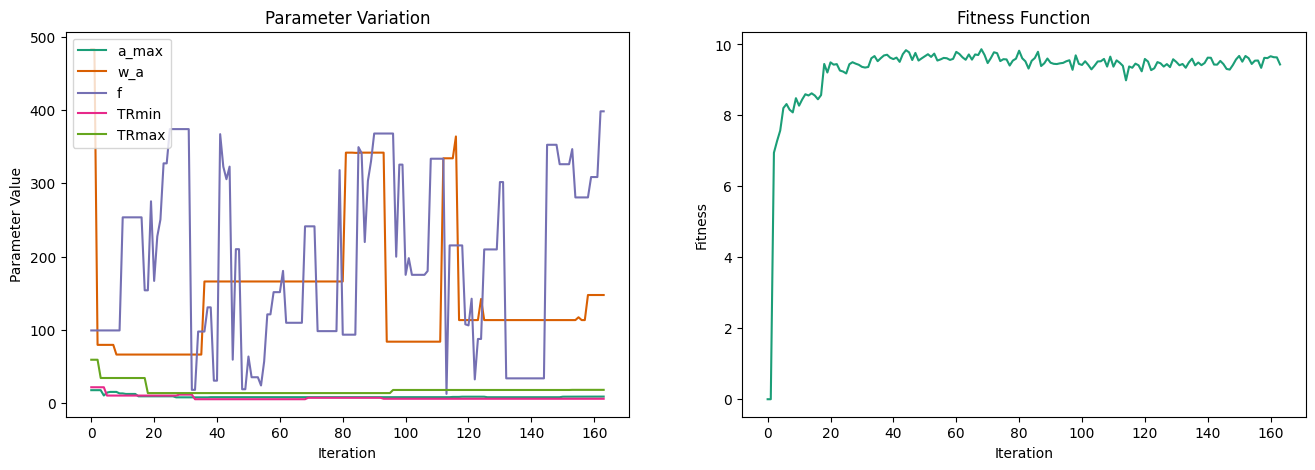

In [25]:
states = np.array(states)
seeBnB(states, costs)

In [ ]:
states = [87.59728498, 229.65485733, 232.88395874,  96.22243265, 197.88738558]
a= states[0]; b = states[1]; c = states[2];  d = states[3]; e = states[4]
TR_array = sinusoidal_TR(d, e, c, 2000, instance)
FA_array = sinusoidal_FA(a, 2000, b, instance)
plt.plot(TR_array[1:])
plt.title('TR (ms)')
plt.xlabel('Dynamic')
plt.ylabel('Time (ms)')

In [ ]:
plt.plot(FA_array[1:])
np.max(FA_array[1:])
plt.title('FA (deg)')
plt.xlabel('Dynamic')
plt.ylabel('Angle')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Fourier series parameters
T = 100  # Period of the function
a0 = 500  # Mean value (baseline TR)
N = 5  # Number of terms in the series
A = 100  # Amplitude of the Fourier components

# Generate random Fourier coefficients for the demonstration
np.random.seed(0)
a_n = A * np.random.randn(N)
b_n = A * np.random.randn(N)

# Time points
t = np.linspace(0, T, 1000)

# Compute the Fourier series
TR = a0 + np.zeros_like(t)
for n in range(1, N + 1):
    TR += a_n[n-1] * np.cos(2 * np.pi * n * t / T) + b_n[n-1] * np.sin(2 * np.pi * n * t / T)

# Plot the TR variation
plt.plot(t, TR)
plt.xlabel('Time (s)')
plt.ylabel('Repetition Time (ms)')
plt.title('TR Variation using Fourier Series')
plt.show()


### Branch and Bound Algorithm Without Parallelisation

In [ ]:
def BnB(start, costFunction, trVariation, maxsteps, instance):

    # Initialise random start point and calculate associated cost
    a_max, w_a, f, TRmin, TRmax = start(trVariation)
    cost = costFunction(a_max, w_a, f, TRmin, TRmax, trVariation, noOfRepetitions, instance)
    
    # Update the current state
    state = [a_max, w_a, f, TRmin, TRmax]
    states, costs = [state], [cost]
    state = np.array(state)
    ## Correct shape of arrays for concatenation 
    state = np.expand_dims(state, axis=0)
    states = np.expand_dims(np.squeeze(states), axis=0)

    ## Set start point current best state 
    bestCost = cost
    bestState = state
    costInd = 0

    # loop over user defined number of iterations
    for it in range (maxsteps):
        
        ## correct dimensions if required 
        if bestState.ndim == 1: 
            bestState = np.expand_dims(bestState, axis=0)
        
        ## save best values to arrays   
        states = np.append(states, bestState, axis=0)
        costs = np.append(costs, bestCost)

        ##  create the permutation array
        if int(np.size(state,0)) == 0 or int(np.size(state,0)) == 1:
               state = bestState
               
        permutations = state

        ## display the number of open branches 
        print(str(int(np.size(state,0)*5)) + ' open branches.')

              ##  iterate over each branch 
        for jj in range(int(np.size(state,0))):
            
            ## repeat each branch 5 times and generate permutations of the current state by varying each parameter.
            permutation = mat.repmat(state[jj,:],5,1)
            aHold, bHold, cHold, dHold, eHold = start(trVariation)
            stateHold = [aHold,bHold,cHold,dHold,eHold]
            
            ##  vary one pararameter at a time
            for xx in range(5):
               permutation[xx,xx] = stateHold[xx] 
               
            ## add new 5 permutations to the array of states
            permutations = np.append(permutations, permutation, axis=0)
               
        ##  Calculate costs for all states
        costsHold = np.zeros([np.size(permutations,0)])
        for jj in range(np.size(permutations,0)):
            costHold = costFunction(permutations[jj,0],permutations[jj,1],\
                                      permutations[jj,2], permutations[jj,3],\
                                      permutations[jj,4],trVariation, noOfRepetitions, instance)
            costsHold[jj] = costHold
            
        ##  Remove values lower that the best cost from the branch above 
        indRem = np.array(np.argwhere(costsHold >= bestCost))
        permArray = np.array(permutations)
        for remove in indRem[::-1]:
            permArray = np.delete(permArray,remove, 0)
        state = permArray
        
        ##  find the best state and cost 
        bestCost = np.min(costsHold)
        costInd = np.argmin(costsHold)
        bestState = permutations[costInd,:]

        ##  print state and cost to screen
        ##  write the latest step t ofile

        print('Step = '  + str(it+1) + '/' + str(maxsteps) + '. State =' + \
            str(permutations[costInd,:]) + '. Cost = ' +  str("{:.5e}".format(bestCost)))
        print("  ")
     

    return state, costFunction(a_max, w_a, f, TRmin, TRmax, trVariation, noOfRepetitions,instance), states, costs

In [ ]:
state, cost, states, costs = BnB(start, costFunction, 'sin', maxsteps=1, instance=5)
states = np.array(states)


In [ ]:
%lprun -f main_loop main_loop()

In [ ]:
seeBnB(states, costs)

In [ ]:
np.mincosts

In [ ]:
a= 83.45295079; b = 489; c = 212.59875526;  d = 77.17032474; e = 144.50796355
TR_array = sinusoidal_TR(d, e, c, 2000, instance)
FA_array = sinusoidal_FA(a, 2000, b, instance)
plt.plot(TR_array[1:])


In [ ]:
plt.plot(FA_array[1:])

Define functions for TR and FA variations based on sinusoidal patterns

In [ ]:
def TRdynamics(f,TRmin,TRmax, noOfRepetitions, instance):
    #SINUSOIDAL TR
    #Generate linearly spaced array between 0 and the number repetitions 
    xRange = np.linspace(0,noOfRepetitions,num=noOfRepetitions)
    #Calculate the sinusoidal array 
    trArray = TRmax*np.sin(xRange/f)+(TRmin+TRmax)

    #Save array for calling in the main function later
    np.save('./holdArrays/trArray_' + str(instance) + '.npy', trArray)

def FAdynamics(a_max,w_a, noOfRepetitions, instance):
    #SINUSOIDAL FA
    xRange = np.array(range(noOfRepetitions))
    #Calculate the sinusoidal array 
    faArray = np.squeeze(a_max*(np.abs(3*np.sin(xRange/w_a)+(np.sin(xRange/w_a)**2))) \
        +  np.random.uniform(0,0,[1,noOfRepetitions]))
    # There may be a loss of SNR when the first flip angle is v low (e.g. 0.008)
    # so change the first flip angle to be a little higher
    faArray[0] = 3 
     #Save array for calling in the main function later
    np.save('./holdArrays/faArray_'  + str(instance) + '.npy', faArray)

Helper functions for the branch-and-bound (cost, initalisation etc)

In [ ]:
def cost(params_min, params_max):
    # Function to minimise--need to run twice for smallest and largest of each range
    dictionaryGenerator_min =  DictionaryGeneratorFast(params_min)
    signal1 = dictionaryGenerator_min.MRFSGRE()[:,0]
    dictionaryGenerator_max =  DictionaryGeneratorFast(params_max)
    signal2 = dictionaryGenerator_max.MRFSGRE()[:,0]
    rmse = -np.sqrt(mean_squared_error(signal1, signal2))
    return rmse

def randomInitialise(optimiseIntervals):
    a_max = random.uniform(optimiseIntervals[0,0], optimiseIntervals[0,1])
    w_a = random.uniform(optimiseIntervals[1,0], optimiseIntervals[1,1])
    f = random.uniform(optimiseIntervals[2,0], optimiseIntervals[2,1])
    TRmin = random.uniform(optimiseIntervals[3,0], optimiseIntervals[3,1])
    TRmax = random.uniform(optimiseIntervals[4,0], optimiseIntervals[4,1])
    
    return a_max, w_a, f, TRmin, TRmax

def visualise(states, costs):
    fig, ax = plt.subplots()
    plt.subplot(121)
    fig.set_size_inches(16,5, forward=True)
    plt.plot(states[:,0],'r')
    plt.plot(states[:,1],'b')
    plt.plot(states[:,2],'k')
    plt.plot(states[:,3],'g')
    plt.plot(states[:,4],'c')
    plt.title("Parameter Variation")
    plt.legend(["a_max","w_a","f","TRmin","TRmax"])
    plt.xlabel("Iteration")
    plt.ylabel("Parameter Value")
    plt.subplot(122)
   
    plt.plot(-costs, 'b')
    plt.title("Fitness Function")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")


In [ ]:
def branch_and_bound(maxsteps,instance):
    ##  Get start point and then calculate cost
    a_max, w_a, f, TRmin, TRmax = randomInitialise(interval)
    current_cost = cost(params_min, params_max)
    state = [a_max, w_a, f, TRmin, TRmax]
    states, costs = [state], [current_cost] 
    state = np.array(state)
    
    ## Correct shape of arrays for concatenation 
    state = np.expand_dims(state, axis=0)
    states = np.expand_dims(np.squeeze(states), axis=0)
    
    ## Set start point current best state 
    bestCost = current_cost
    bestState = state
    costInd = 0
    
    ##  loop over user defined number of iterations 
    for ii in range(maxsteps):
        
        ## correct dimensions if required 
        if bestState.ndim == 1: 
            bestState = np.expand_dims(bestState, axis=0)
            
        ## save best values to arrays   
        states = np.append(states, bestState, axis=0)
        costs = np.append(costs, bestCost)
        
        ##  create the permutation array
        if int(np.size(state,0)) == 0 or int(np.size(state,0)) == 1:
               state = bestState
        permutations = state
        
        ## display the number of open branches 
        print(str(int(np.size(state,0)*5)) + ' open branches.')
        
        ##  iterate over each branch 
        for jj in range(int(np.size(state,0))):
            
            ## repeat each branch 5 times 
            permutation = mat.repmat(state[jj,:],5,1)
            aHold, bHold, cHold, dHold, eHold = randomInitialise(trVariation)
            stateHold = [aHold,bHold,cHold,dHold,eHold]
            
            ##  permute one pararameter at a time
            for xx in range(5):
               permutation[xx,xx] = stateHold[xx] 
               
            ## add new 5 permutations to the array of states
            permutations = np.append(permutations, permutation, axis=0)
               
        ##  Calculate costs for all states
        costsHold = np.zeros([np.size(permutations,0)])
        for jj in range(np.size(permutations,0)):
            costHold = cost(permutations[jj,0],permutations[jj,1],\
                                      permutations[jj,2], permutations[jj,3],\
                                      permutations[jj,4],trVariation, noOfRepetitions, instance)
            costsHold[jj] = costHold
            
        ##  Remove values lower that the best cost from the branch above 
        indRem = np.array(np.argwhere(costsHold >= bestCost))
        permArray = np.array(permutations)
        for remove in indRem[::-1]:
            permArray = np.delete(permArray,remove, 0)
        state = permArray
        
        ##  find the best state and cost 
        bestCost = np.min(costsHold)
        costInd = np.argmin(costsHold)
        bestState = permutations[costInd,:]

        ##  print state and cost to screen
        ##  write the latest step t ofile
        '''
        output = 'Step = '  + str(ii+1) + '/' + str(maxsteps) + '. State =' + \
            str(permutations[cost_ind,:]) + '. Cost = ' +  str(best_cost) + '.' + \
            str(np.size(state,1)) + ' open branches.'
        '''
        print('Step = '  + str(ii+1) + '/' + str(maxsteps) + '. State =' + \
            str(permutations[costInd,:]) + '. Cost = ' +  str("{:.5e}".format(bestCost)))
        print("  ")
        '''
        with open("console_output.txt", "w") as myFile:
            myFile.write(str(output))
        '''

    return state, cost(a_max, w_a, f, TRmin, TRmax, noOfRepetitions,instance), states, costs

In [ ]:
state, cost, states, costs = branch_and_bound(maxsteps=1, instance=3)


In [ ]:
states = np.array(states)
seeAnnealing(states, costs)